In [ ]:
!pip install pyspark yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e03d20d1d087a4176821e2f6036fea3565f32b60bc04fae163f6fa6775411148
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import yfinance as yf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, when
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


In [ ]:
spark = SparkSession.builder \
    .appName("StockMarketPrediction") \
    .getOrCreate()


In [ ]:
sp500 = yf.Ticker("^GSPC")
df = sp500.history(period="max")


In [ ]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-22 00:00:00-04:00,5242.479980,5246.089844,5229.870117,5234.180176,3374700000,0.0,0.0
2024-03-25 00:00:00-04:00,5219.520020,5229.089844,5216.089844,5218.189941,3331360000,0.0,0.0
2024-03-26 00:00:00-04:00,5228.850098,5235.160156,5203.419922,5203.580078,3871790000,0.0,0.0


In [ ]:
stock_data = df.drop(columns=['Dividends', 'Stock Splits'])

In [ ]:
stock_data

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2024-03-22 00:00:00-04:00,5242.479980,5246.089844,5229.870117,5234.180176,3374700000
2024-03-25 00:00:00-04:00,5219.520020,5229.089844,5216.089844,5218.189941,3331360000
2024-03-26 00:00:00-04:00,5228.850098,5235.160156,5203.419922,5203.580078,3871790000


In [ ]:
spark_df = spark.createDataFrame(stock_data.reset_index())


In [ ]:
spark_df.show()

+-------------------+------------------+------------------+------------------+------------------+------+
|               Date|              Open|              High|               Low|             Close|Volume|
+-------------------+------------------+------------------+------------------+------------------+------+
|1927-12-30 05:00:00| 17.65999984741211| 17.65999984741211| 17.65999984741211| 17.65999984741211|     0|
|1928-01-03 05:00:00|17.760000228881836|17.760000228881836|17.760000228881836|17.760000228881836|     0|
|1928-01-04 05:00:00|17.719999313354492|17.719999313354492|17.719999313354492|17.719999313354492|     0|
|1928-01-05 05:00:00|17.549999237060547|17.549999237060547|17.549999237060547|17.549999237060547|     0|
|1928-01-06 05:00:00| 17.65999984741211| 17.65999984741211| 17.65999984741211| 17.65999984741211|     0|
|1928-01-09 05:00:00|              17.5|              17.5|              17.5|              17.5|     0|
|1928-01-10 05:00:00|  17.3700008392334|  17.3700008392

In [ ]:
spark_df.dropna()

DataFrame[Date: timestamp, Open: double, High: double, Low: double, Close: double, Volume: bigint]

In [ ]:
from pyspark.sql.functions import mean, stddev

def calculate_features(data):
    # Calculate moving averages
    windowSpec20 = Window.orderBy('Date').rowsBetween(-19, 0)
    windowSpec50 = Window.orderBy('Date').rowsBetween(-49, 0)
    windowSpec200 = Window.orderBy('Date').rowsBetween(-199, 0)

    data = data.withColumn('20d_moving_avg', mean(col('Close')).over(windowSpec20))
    data = data.withColumn('50d_moving_avg', mean(col('Close')).over(windowSpec50))
    data = data.withColumn('200d_moving_avg', mean(col('Close')).over(windowSpec200))

    # Calculate daily returns
    data = data.withColumn('daily_return', (col('Close') - lag('Close', 1).over(Window.orderBy('Date'))) / lag('Close', 1).over(Window.orderBy('Date')))

    # Calculate volatility
    windowSpecVolatility = Window.orderBy('Date').rowsBetween(-19, 0)
    data = data.withColumn('volatility', stddev(col('daily_return')).over(windowSpecVolatility))

    # Calculate change, gain, loss
    data = data.withColumn('change', col('Close') - lag('Close', 1).over(Window.orderBy('Date')))
    data = data.withColumn('gain', when(col('change') > 0, col('change')).otherwise(0))
    data = data.withColumn('loss', when(col('change') < 0, -col('change')).otherwise(0))

    return data.dropna()


In [ ]:
# Calculate features
spark_df = calculate_features(spark_df)

In [ ]:
spark_df.show()

+-------------------+------------------+------------------+------------------+------------------+------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Date|              Open|              High|               Low|             Close|Volume|    20d_moving_avg|    50d_moving_avg|   200d_moving_avg|        daily_return|          volatility|              change|                gain|                loss|
+-------------------+------------------+------------------+------------------+------------------+------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|1928-01-06 05:00:00| 17.65999984741211| 17.65999984741211| 17.65999984741211| 17.65999984741211|     0|17.643332799275715|17.643332799275715|17.643332799275715|0.006267841318150765| 0.01121579220825

In [ ]:
# Train-test split (for demonstration purposes, actual implementation may vary)
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=123)


In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

def train_model(data):
    assembler = VectorAssembler(
        inputCols=['Open', 'High', 'Low', 'Close', 'Volume',
                   '20d_moving_avg', '50d_moving_avg', '200d_moving_avg',
                   'daily_return', 'volatility', 'change', 'gain', 'loss'],
        outputCol='features')

    data = assembler.transform(data)

    rf = RandomForestRegressor(featuresCol='features', labelCol='Close')

    # Define a grid of hyperparameters
    param_grid = ParamGridBuilder() \
        .addGrid(rf.maxDepth, [5, 10, 15]) \
        .addGrid(rf.numTrees, [50, 100, 150]) \
        .build()

    # Initialize CrossValidator
    crossval = CrossValidator(estimator=rf,
                              estimatorParamMaps=param_grid,
                              evaluator=RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='rmse'),
                              numFolds=3)

    # Run cross-validation, and choose the best set of parameters
    cv_model = crossval.fit(data)

    # Get the best model from cross-validation
    best_model = cv_model.bestModel

    return best_model


In [ ]:
# Train model
model = train_model(train_data)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

def evaluate_model(model, data):
    assembler = VectorAssembler(
        inputCols=['Open', 'High', 'Low', 'Close', 'Volume',
                   '20d_moving_avg', '50d_moving_avg', '200d_moving_avg',
                   'daily_return', 'volatility', 'change', 'gain', 'loss'
                  ],
        outputCol='features')

    data = assembler.transform(data)

    predictions = model.transform(data)

    # Calculate RMSE
    evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='rmse')
    rmse = evaluator.evaluate(predictions)

    print("Root Mean Squared Error (RMSE) on Test Data:", rmse)
    return predictions



In [ ]:
# Call evaluate_model function in your main script
predictions = evaluate_model(model, test_data)

Root Mean Squared Error (RMSE) on Test Data: 65.31721414011534


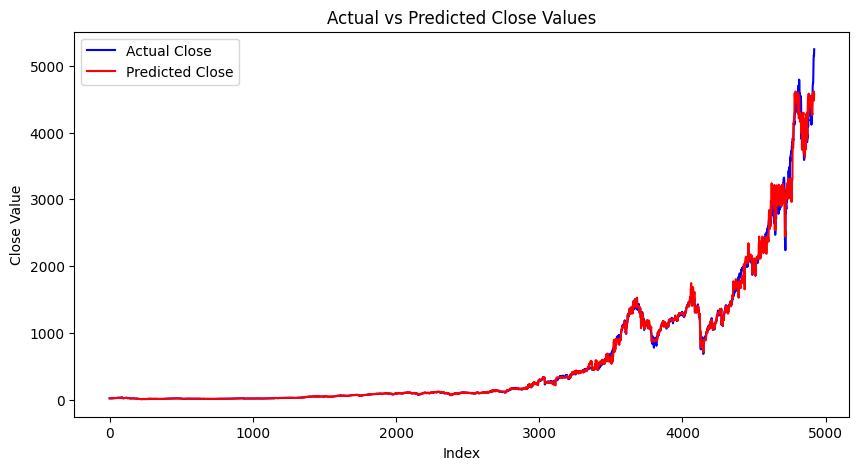

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(predictions):
    actual_close = predictions.select('Close').collect()
    predicted_close = predictions.select('prediction').collect()

    actual_close_values = [row.Close for row in actual_close]
    predicted_close_values = [row.prediction for row in predicted_close]

    plt.figure(figsize=(10, 5))
    plt.plot(actual_close_values, label='Actual Close', color='blue')
    plt.plot(predicted_close_values, label='Predicted Close', color='red')
    plt.xlabel('Index')
    plt.ylabel('Close Value')
    plt.title('Actual vs Predicted Close Values')
    plt.legend()
    plt.show()

# Call plot_predictions function in your main script
plot_predictions(predictions)


In [ ]:
# Train-test split (for demonstration purposes, actual implementation may vary)
train_data_2, test_data_2 = spark_df.randomSplit([0.8, 0.2], seed=123)

In [ ]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

def train_model(data):
    assembler = VectorAssembler(
        inputCols=['Open', 'High', 'Low', 'Close', 'Volume',
                   '20d_moving_avg', '50d_moving_avg', '200d_moving_avg',
                   'daily_return', 'volatility', 'change', 'gain', 'loss'],
        outputCol='features')

    data = assembler.transform(data)

    # Initialize models
    rf = RandomForestRegressor(featuresCol='features', labelCol='Close', predictionCol='rf_prediction')
    gbt = GBTRegressor(featuresCol='features', labelCol='Close', predictionCol='gbt_prediction')

    # Create a pipeline
    pipeline = Pipeline(stages=[rf, gbt])

    # Train the pipeline
    model = pipeline.fit(data)

    return model


In [ ]:
model_2 = train_model(train_data_2)

In [ ]:
def evaluate_model(model, data):
    # Apply feature vector assembler
    assembler = VectorAssembler(
        inputCols=['Open', 'High', 'Low', 'Close', 'Volume',
                   '20d_moving_avg', '50d_moving_avg', '200d_moving_avg',
                   'daily_return', 'volatility', 'change', 'gain', 'loss'],
        outputCol='features')

    data = assembler.transform(data)

    # Make predictions
    predictions = model.transform(data)

    # Calculate RMSE for RandomForestRegressor
    evaluator_rf = RegressionEvaluator(labelCol='Close', predictionCol='rf_prediction', metricName='rmse')
    rmse_rf = evaluator_rf.evaluate(predictions)

    # Calculate RMSE for GBTRegressor
    evaluator_gbt = RegressionEvaluator(labelCol='Close', predictionCol='gbt_prediction', metricName='rmse')
    rmse_gbt = evaluator_gbt.evaluate(predictions)

    print("Root Mean Squared Error (RMSE) for RandomForestRegressor:", rmse_rf)
    print("Root Mean Squared Error (RMSE) for GBTRegressor:", rmse_gbt)

    return predictions

In [ ]:
predictions = evaluate_model(model_2, test_data_2)  # Assuming test_data is your test dataset

Root Mean Squared Error (RMSE) for RandomForestRegressor: 80.48615980219331
Root Mean Squared Error (RMSE) for GBTRegressor: 72.43421762039462


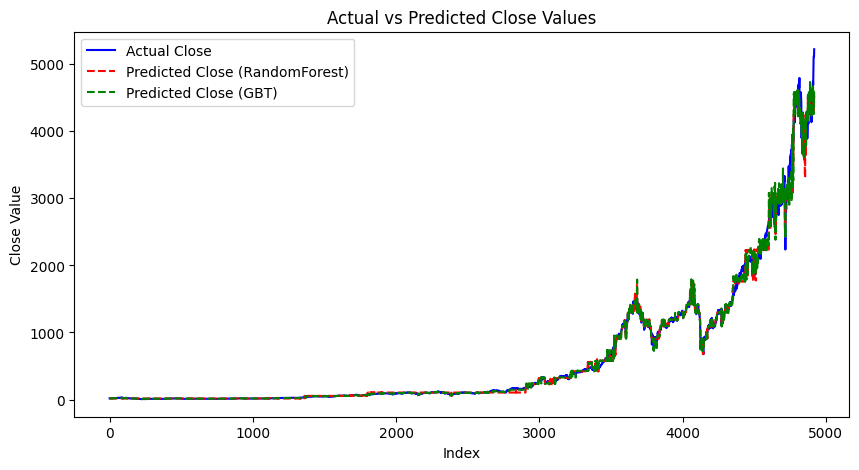

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(predictions):
    actual_values = predictions.select('Close').collect()
    predicted_values_rf = predictions.select('rf_prediction').collect()
    predicted_values_gbt = predictions.select('gbt_prediction').collect()

    actual_values = [row.Close for row in actual_values]
    predicted_values_rf = [row.rf_prediction for row in predicted_values_rf]
    predicted_values_gbt = [row.gbt_prediction for row in predicted_values_gbt]

    plt.figure(figsize=(10, 5))
    plt.plot(actual_values, label='Actual Close', color='blue')
    plt.plot(predicted_values_rf, label='Predicted Close (RandomForest)', color='red', linestyle='--')
    plt.plot(predicted_values_gbt, label='Predicted Close (GBT)', color='green', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Close Value')
    plt.title('Actual vs Predicted Close Values')
    plt.legend()
    plt.show()

# Example usage:
plot_predictions(predictions)
